In [43]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as scp
import netCDF4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os

In [44]:
file_path1 = 'TropicsOcean1.nc'
file_path2 = 'TropicsOcean2.nc'
file_path3 = 'TropicsOcean3.nc'

#Opening dataset for tropics                                   
dsT1 = xr.open_dataset(file_path1)
dsT2 = xr.open_dataset(file_path2)
dsT3 = xr.open_dataset(file_path3)


In [55]:
merged_ds = xr.merge([dsT1,dsT2,dsT3])

In [46]:
dsT2

<xarray.Dataset>
Dimensions:    (longitude: 41, latitude: 41, time: 30680)
Coordinates:
  * longitude  (longitude) float32 110.0 110.2 110.5 110.8 ... 119.5 119.8 120.0
  * latitude   (latitude) float32 20.0 19.75 19.5 19.25 ... 10.5 10.25 10.0
  * time       (time) datetime64[ns] 2002-01-01 ... 2022-12-31T18:00:00
Data variables:
    cp         (time, latitude, longitude) float32 ...
    sp         (time, latitude, longitude) float32 ...
    tcc        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-29 06:00:42 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

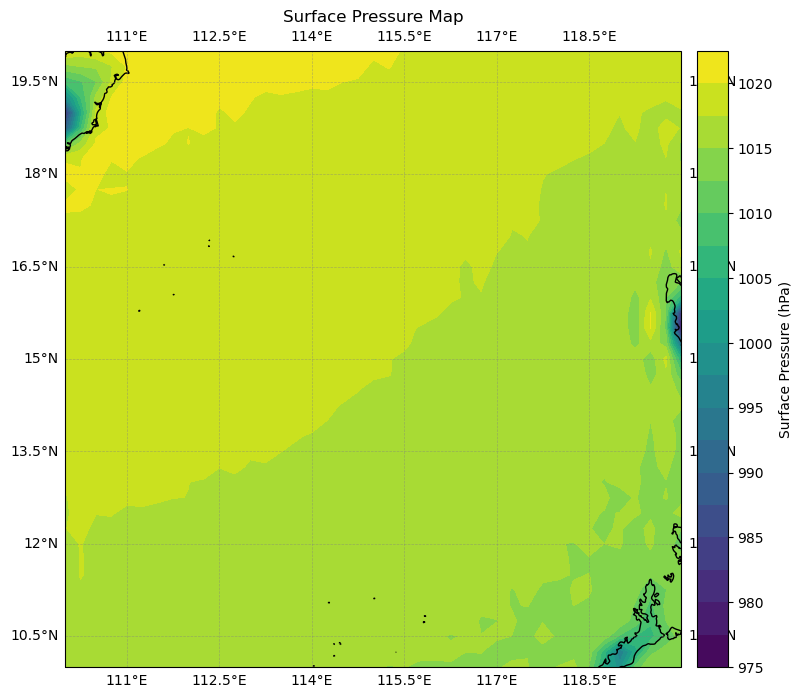

In [47]:
time_index = 0
surface_pressure_slice = dsT2['sp'][time_index, :, :]

# Create a map using Cartopy
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot surface pressure data
c = ax.contourf(dsT2['longitude'], dsT2['latitude'], (surface_pressure_slice/100), transform=ccrs.PlateCarree(), cmap='viridis', levels=20)

# Add coastlines and country borders
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add gridlines
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Add colorbar
cb = plt.colorbar(c, ax=ax, orientation='vertical', pad=0.02, aspect=20)
cb.set_label('Surface Pressure (hPa)')

# Add a title
plt.title('Surface Pressure Map')

# Show the plot
plt.show()

In [48]:
avg_dsMT = merged_ds.mean(dim=['latitude', 'longitude'])  

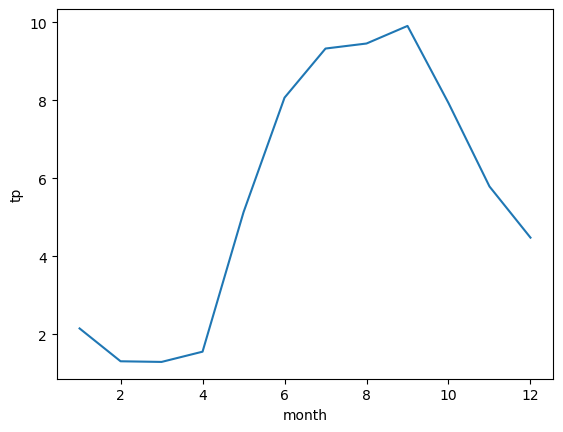

In [49]:
tp_mmpd = merged_ds['tp']*1e3*24
tp_spatial = tp_mmpd.mean(dim = ['latitude','longitude'])
tp_seasonal = tp_spatial.groupby('time.month').mean()
tp_seasonal.plot()

In [50]:
First_monsoon = avg_dsMT.sel(time=avg_dsMT['time.month'].isin([4, 5, 6]))

Second_monsoon = avg_dsMT.sel(time=avg_dsMT['time.month'].isin([7, 8, 9]))

In [51]:
cape_bins = np.linspace(0, 2500, 17)
cins = []
tps = []
for data in (First_monsoon, Second_monsoon):
    positive_precip = data['tp'].where((data['tp']*24000) > 1.0)
    cape_positive_precip = data['cape'].where((data['tp']*24000) > 1.0)
    binned_precipitation = positive_precip.groupby_bins(cape_positive_precip, bins=cape_bins)
    binned_cin = data['cin'].groupby_bins(cape_positive_precip, bins=cape_bins)
    avgcin = binned_cin.mean()
    avgtp = binned_precipitation.mean()
    cape_mid = (cape_bins[1:] + cape_bins[:-1])/2
    cins.append(avgcin)
    tps.append(avgtp)

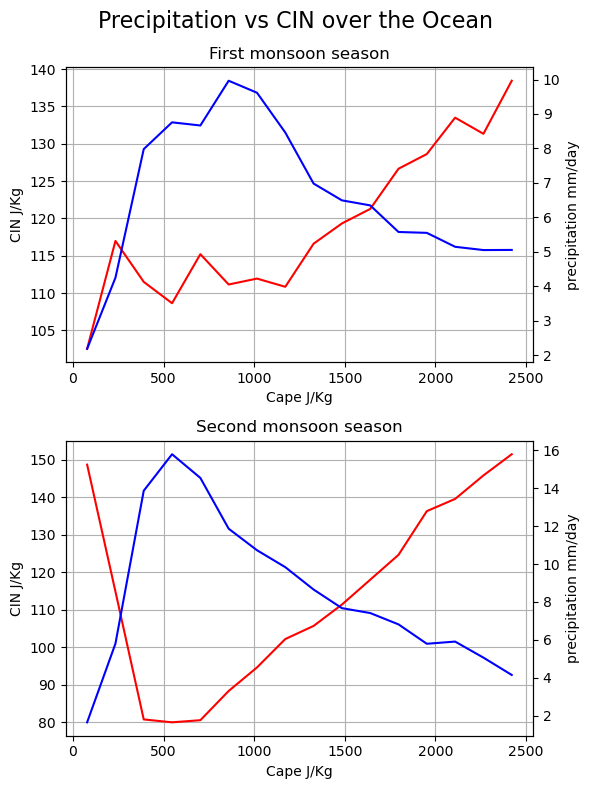

In [52]:
fig, axs = plt.subplots(2, 1, figsize=(6, 8))

# Assuming cins and tps are lists with two elements each
for idx, (season, avgcin, avgtp) in enumerate(zip(["First monsoon season", "Second monsoon season"], cins, tps)):

    axs[idx].plot(cape_mid, avgcin, color='r', label=f'{season}')
    axs[idx].set_xlabel('Cape J/Kg')
    axs[idx].set_ylabel('CIN J/Kg')
    axs[idx].set_title(f'{season}')
    axs[idx].grid(True)
    ax2 = axs[idx].twinx()
    ax2.plot(cape_mid, avgtp * 24000, 'b-', label='cape')
    ax2.set_ylabel('precipitation mm/day')
    ax2.tick_params(axis='y')

plt.suptitle("Precipitation vs CIN over the Ocean", fontsize=16)
plt.tight_layout()
plt.show()

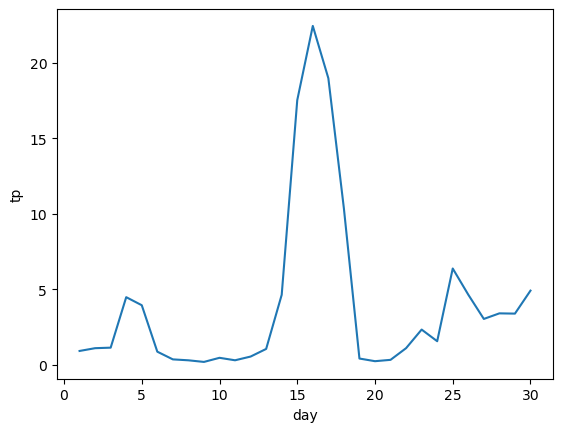

In [53]:
April08 = avg_dsMT.sel(time=slice('2008-04-01', '2008-04-30'))
April08_daily = April08.groupby('time.day').mean()
April08_tp = April08_daily['tp']*24000
April08_cape = April08_daily['cape']
April08_tp.plot()


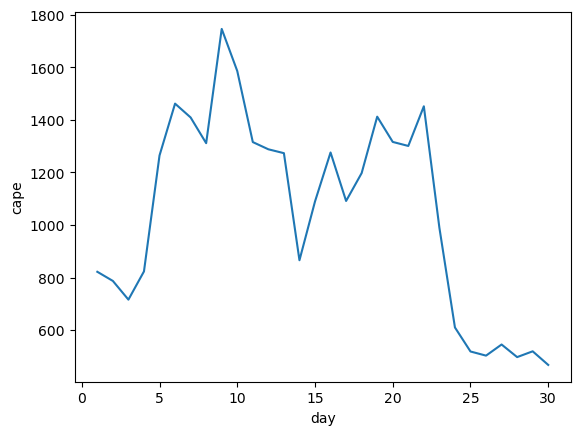

In [54]:
April08_cape.plot()

![](SouthChina.jpeg)